In [3]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


In [5]:
data = load_wine()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [7]:
cov_mat = np.cov(X_train_std.T)
eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
print(eigen_vals)

[4.7095539  2.63606471 1.55728758 0.93422662 0.85129454 0.5709688
 0.46462025 0.37764772 0.10409155 0.14951983 0.21165109 0.2630501
 0.27571434]


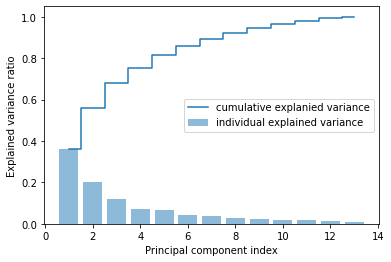

In [8]:
tot = sum(eigen_vals)
var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

import matplotlib.pyplot as plt
plt.bar(range(1, 14), var_exp, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1, 14), cum_var_exp, where='mid', label='cumulative explanied variance')
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.legend(loc='best')
plt.show()

In [10]:
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs.sort(key=lambda k: k[0], reverse=True)
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))

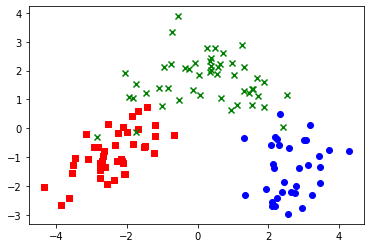

In [12]:
X_train_pca = X_train_std.dot(w)
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(X_train_pca[y_train == l, 0],
                X_train_pca[y_train == l, 1],
                c=c, label=l, marker=m)


In [16]:
# LDA
# step 1 normalize data
# step 2 calc mean vecs in each classification
mean_vecs = []
labels = np.unique(y_train)
for idx, label in enumerate(labels):
    mean_vecs.append(np.mean(X_train_std[y_train==label], axis=0))
    print("MV %s: %s\n: " %(label, mean_vecs[idx]))

MV 0: [ 0.89976216 -0.35996329  0.30103147 -0.74304582  0.46792414  0.91761752
  0.98085519 -0.6287134   0.64032575  0.20178957  0.49581041  0.76416637
  1.16973167]
: 
MV 1: [-0.91914645 -0.36134188 -0.36704181  0.29261151 -0.43620895 -0.11871457
  0.00975796  0.10976533 -0.02351051 -0.85559328  0.37199541  0.23427044
 -0.76986063]
: 
MV 2: [ 0.27475981  0.99471481  0.18211516  0.47982737  0.07956236 -0.9601997
 -1.23342305  0.61481767 -0.75993424  1.04564521 -1.17963629 -1.30437403
 -0.28684748]
: 


TypeError: Cannot interpret '13' as a data type

In [19]:
# step 3 calc S_W by mean_vecs
d = X_train_std.shape[1]
S_W = np.zeros((d, d))
for label, mv in zip(labels, mean_vecs):
    class_scatter = np.zeros((d, d))
    for row in X_train_std[y_train == label]:
        row, mv = row.reshape(d, 1), mv.reshape(d, 1)
        class_scatter += (row - mv).dot((row - mv).T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [20]:
# step 3 an simplified solution:
S_W = np.zeros((d, d))
for label, mv in zip(labels, mean_vecs):
    class_scatter = np.cov(X_train_std[y_train==label].T)
    S_W += class_scatter
print('Within-class scatter matrix: %sx%s' %(S_W.shape[0], S_W.shape[1]))

Within-class scatter matrix: 13x13


In [21]:
# step 4 calc S_B
mean_overall = np.mean(X_train_std, axis=0)
S_B = np.zeros((d,d))
for i, mean_vec in enumerate(mean_vecs):
    n = X_train[y_train == i, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)
    S_B += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)
print("Between class scatter matrix: %sx%s" % (S_B.shape[0], S_B.shape[1]))

Between class scatter matrix: 13x13


In [23]:
# step 5 calc eigenvalues and eigenvectors for S_W^-1 * S_B
# step 6 sort by eigenvalues
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(S_W).dot(S_B))
eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
for eigen_val in eigen_pairs:
    print(eigen_val[0])

5150.751007396082
2390.884352250747
6.960952657648625e-13
6.960952657648625e-13
3.1281737772071424e-13
3.1281737772071424e-13
1.9998801247074354e-13
1.9998801247074354e-13
1.6795958713347512e-13
1.4160099898853998e-13
8.808178612845331e-14
8.808178612845331e-14
0.0


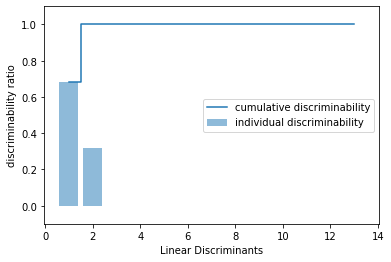

In [24]:
tot = sum(eigen_vals.real)
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
cum_discr = np.cumsum(discr)

plt.bar(range(1, 14), discr, alpha=0.5, align='center', label='individual discriminability')
plt.step(range(1, 14), cum_discr, where='mid', label='cumulative discriminability')
plt.xlabel('Linear Discriminants')
plt.ylabel('discriminability ratio')
plt.legend(loc='best')
plt.ylim([-0.1, 1.1])
plt.show()

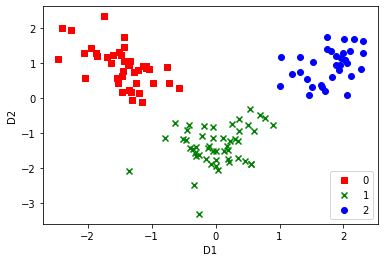

In [25]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis].real,
               eigen_pairs[1][1][:, np.newaxis].real))
X_train_lda = X_train_std.dot(w)
colors = ['r', 'g', 'b']
markers = ['s', 'x', 'o']
for l, c, m in zip(labels, colors, markers):
    plt.scatter(X_train_lda[y_train==l, 0],
                X_train_lda[y_train==l, 1] * (-1),
                c=c,
                label = l,
                marker =m )
plt.xlabel("D1")
plt.ylabel("D2")
plt.legend(loc='lower right')
plt.show()


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


def plot_decision_region(X, y, classifier, test_idx=None, resolution=0.02):
    """
    plot decision region by X[:, 0], X[:, 1]
    """
    markers = ['s', 'x', 'o', '^', 'v']
    colors = ['red', 'blue', 'lightgreen', 'gray', 'cyan']
    unique_y = np.unique(y)
    cmap = ListedColormap(colors[:len(unique_y)])

    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution), np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(unique_y):
        plt.scatter(X[y == cl, 0],
                    X[y == cl, 1],
                    alpha=0.8,
                    c = colors[idx],
                    marker = markers[idx],
                    label = cl,
                    edgecolor='black')

    if test_idx:
        X_test, y_test = X[test_idx, :], y[test_idx]
        plt.scatter(
            x=X_test[:, 0],
            y=X_test[:, 1],
            c='',
            edgecolors='black',
            alpha=1.0,
            linewidths=1,
            marker='o',
            s=100,
            label='test set'
        )

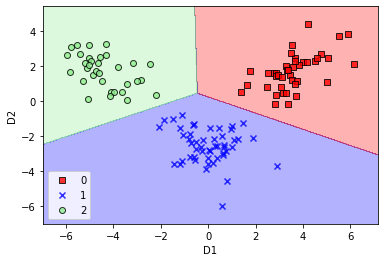

In [27]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train_std, y_train)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train_lda, y_train)
plot_decision_region(X_train_lda, y_train, classifier=lr)
plt.xlabel('D1')
plt.ylabel('D2')
plt.legend(loc='lower left')
plt.show()

In [14]:
# kernel principal component analysis
from scipy.spatial.distance import pdist, squareform
from scipy.linalg import eigh
import numpy

def rbf_kernel_pca(X, gamma, n_components):
    sq_dists = pdist(X, 'sqeuclidean')
    mat_sq_dists = squareform(sq_dists)
    K = np.exp(-gamma * mat_sq_dists)

    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

    eigvals, eigvecs = eigh(K)
    eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

    X_pc = np.column_stack((eigvecs[:, i] for i in range(n_components)))

    return X_pc

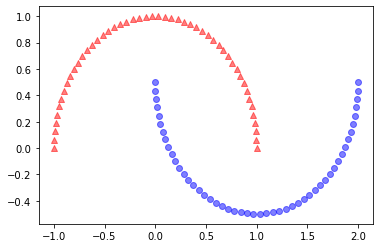

In [6]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, random_state=123)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

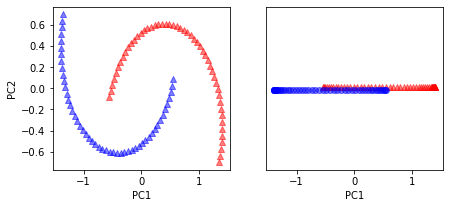

In [8]:
# normal pca doesn't slove the problem well
from sklearn.decomposition import PCA
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fit, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

<ipython-input-14-7824cdc093a2>:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X_pc = np.column_stack((eigvecs[:, i] for i in range(n_components)))


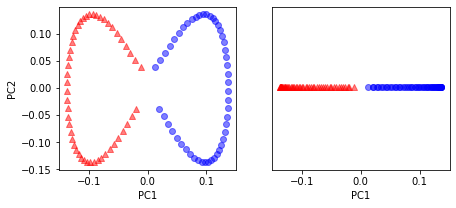

In [15]:
# using kernel pca
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y == 0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((50, 1)) + 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

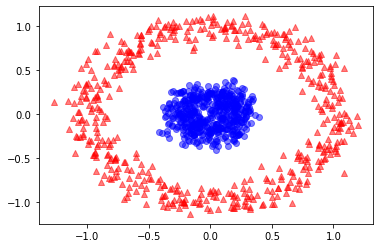

In [17]:
from sklearn.datasets import make_circles
X, y = make_circles(n_samples=1000, random_state=123, noise=0.1, factor=0.2)
plt.scatter(X[y==0, 0], X[y==0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y==1, 0], X[y==1, 1], color='blue', marker='o', alpha=0.5)
plt.show()

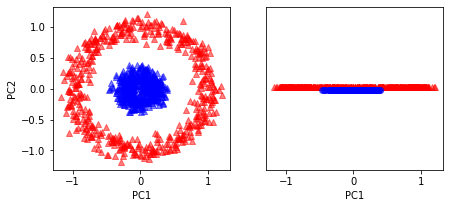

In [19]:
scikit_pca = PCA(n_components=2)
X_spca = scikit_pca.fit_transform(X)
fit, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].scatter(X_spca[y==0, 0], X_spca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_spca[y==1, 0], X_spca[y==1, 1], color='blue', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_spca[y==1, 0], np.zeros((500, 1)) - 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()

<ipython-input-14-7824cdc093a2>:18: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  X_pc = np.column_stack((eigvecs[:, i] for i in range(n_components)))


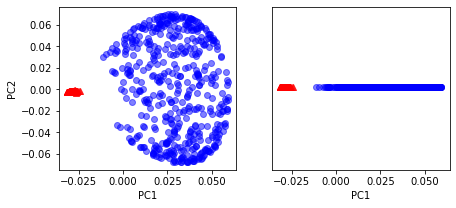

In [20]:
X_kpca = rbf_kernel_pca(X, gamma=15, n_components=2)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))
ax[0].scatter(X_kpca[y == 0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
ax[0].scatter(X_kpca[y == 1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)
ax[1].scatter(X_kpca[y == 0, 0], np.zeros((500, 1)) + 0.02, color='red', marker='^', alpha=0.5)
ax[1].scatter(X_kpca[y == 1, 0], np.zeros((500, 1)) + 0.02, color='blue', marker='o', alpha=0.5)
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[1].set_ylim([-1, 1])
ax[1].set_yticks([])
ax[1].set_xlabel('PC1')
plt.show()